<a href="https://colab.research.google.com/github/meridah7/Lily/blob/main/5_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5. Quantization**


## 5.0 Setup Capabilities

In [55]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [5]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/a2-meridah7
fatal: Unable to create '/content/gdrive/MyDrive/ece5545/a2-meridah7/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 160.16 KiB | 2.76 MiB/s, done.
From https://github.com/ML-HW-SYS/a2-meridah7
   2573605..82bbf78  main       -> origin/main
You are not currently on a branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

/content/gdrive/MyDrive/ece5545


In [59]:
!git config --global user.email "meridah7@gmail.com"
!git config --global user.name "meridah7"

In [51]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Please verify the cell below prints out the github repository.

In [8]:
!ls '{PROJECT_ROOT}'

1_audio_preprocessing.ipynb	     5_quantization.ipynb	      images	 src
2_size_estimator_and_profiler.ipynb  6_pruning.ipynb		      models	 tests
4_model_conversion.ipynb	     arduino_nano_33_ble_tutorial.md  README.md


### Install required packages

In [ ]:
# Install libraries
!pip install tqdm
!pip install torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Import code dependencies

In [11]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy
import os

import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = RANDOM_SEED
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 5.1 Define Quantization Functions

There are some test cases in the `tests` folder to verify basic functionality of your implemented functions--these will be run automatically every time you check in your code. Additionally, we've left some simple tests in this notebook as well for you to try things out.



#### TODO 0: Implement the backward pass of `ste_round` function in `src/quant.py`

In [ ]:
# add a test if you like. There's already one under tests/


#### TODO 1: Implement the `linear_quantize` function in `src/quant.py`


In [30]:
from src.quant import linear_quantize

# Mini test case for linear_quantize
with torch.no_grad():
    x = torch.tensor([2, -0.5, 0., 1.])
    scale = 1
    zero = 0
    y = linear_quantize(x, scale, zero)
    print(y)

tensor([2., -0., 0., 1.])


#### TODO 2: Implement the `SymmetricQuantFunction` forward function in `src/quant.py`


In [31]:
from src.quant import SymmetricQuantFunction

quant_f = SymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)
print(x.grad)

tensor([1., 0., 0., 1.], grad_fn=<SymmetricQuantFunctionBackward>)
tensor([2., 0., 0., 2.])


#### TODO 3: Implement the `AsymmetricQuantFunction` forward function in `src/quant.py`

In [32]:
from src.quant import AsymmetricQuantFunction

quant_f = AsymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)
print(x.grad)

tensor([2., -0., 0., 1.], grad_fn=<AsymmetricQuantFunctionBackward>)
tensor([4., -0., 0., 2.])


#### TODO 4: Finish the Implement of `get_quantization_params` function in `src/quant.py`

In [33]:
from src.quant import QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)
print(qconfig.get_quantization_params(x.min(), x.max()))

qconfig = QConfig(quant_bits=4, is_symmetric=False)
print(qconfig.get_quantization_params(x.min(), x.max()))

(tensor(0.2857), tensor(0.))
(tensor(0.1667), tensor(3.))


#### TODO 5: Implement the `quantize_weights_bias` function in `src/quant.py`

In [34]:
from src.quant import quantize_weights_bias, QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)

w1 = nn.Parameter(torch.tensor([2, -0.5, 0., 1.]))
qw1 = quantize_weights_bias(w1, qconfig)
print(qw1.data)

w2 = nn.Parameter(torch.tensor([2.5, -1, 0., 1.5]))
qw2 = quantize_weights_bias(w2, qconfig)
print(qw2.data)

tensor([ 7., -2.,  0.,  3.])
tensor([ 7., -3.,  0.,  4.])


## 5.2 Quantization Function for Linear and Convolution Layer

#### TODO 6: Finish the implementation of `conv2d_linear_quantized` function in `src/quant.py`

In [35]:
import torch.nn as nn
from src.quant import QuantWrapper

layer = nn.Linear(2, 2)
layer.weight.data = torch.tensor([[0.1, 0.1], [-0.1, 0.1]]).view(2, 2).float()
layer.bias.data = torch.tensor([1, 2]).view(*layer.bias.shape).float()
x = torch.tensor([[0., 1]])
print(layer(x))

quant_layer = QuantWrapper(
    layer,
    QConfig(quant_bits=4, is_symmetric=True),
    QConfig(quant_bits=4, is_symmetric=True),
    QConfig(quant_bits=4, is_symmetric=True))
print(quant_layer(x))


tensor([[1.1000, 2.1000]], grad_fn=<AddmmBackward0>)
tensor([[0.9571, 2.1000]], grad_fn=<AddBackward0>)


## 5.3 Prepare model for QAT (Quantization Aware Training)

### Get Audio Processor, Devices, Data Loader, and Model

NOTE: This is identical to section 2.2 .

In [18]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
# HINT: In case loading data takes too long, move the dataset from gdrive to /content/ and change the path accordingly.
audio_processor = data_proc.AudioProcessor(data_dir=DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

### Load Pretrained Model for Quantization Aware Finetuning

In this notebook, we will load the previously trained 32-bits float model to finetune it in a quantizaiton-aware way.



In [22]:
! pwd
%cd /content/gdrive/MyDrive/ece5545/models/torch_models/
!ls
TORCH_DIR = "/content/gdrive/MyDrive/ece5545/models/torch_models/"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/models/torch_models
 fp32_checkpoint.pt	      '(QAT4bit)quant_0.pt'   tinyconv_float32_init_seed0_90.28%_0.pt
 fp32_finetune_checkpoint.pt   quant_checkpoint.pt


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [27]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

<ipython-input-27-40e93926a152>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fp32.load_state_dict(torch.load(torch_path))


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

### Define settings for weight and activation quantization

In [36]:
# We choose 4 bit quantization as an example because accuracy improvements will
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 4
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

### Prepare quantization aware training model

In [37]:
from src.quant import quantize_model
qat_model_nbit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_nbit)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): QuantWrapper(
    (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): QuantWrapper(
    (module): Linear(in_features=4000, out_features=4, bias=True)
  	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
  	(bias): quant_bits=4, quant_m

##  5.4 Finetuning

In this training, we will finetune the 32-bits float pretrained model. The goal is to finetune the weights of the 32-bits float model such that the resulted model will have better accuracy after quantization.

### Quantization Aware Finetuning

In [ ]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_nbit, learning_rate=0.001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint.pt")
qat_model_nbit.to(device)
run_training(
    model=qat_model_nbit, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 30 
#total training steps: 3180
{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 90.7%, Train loss = 0.407
Val Acc Epoch 2 = 89.42%, Train loss = 0.388
Val Acc Epoch 3 = 90.17%, Train loss = 0.405
Val Acc Epoch 4 = 86.12%, Train loss = 0.423
Val Acc Epoch 5 = 89.5%, Train loss = 0.411
Val Acc Epoch 6 = 87.4%, Train loss = 0.476
Val Acc Epoch 7 = 86.72%, Train loss = 0.467
Val Acc Epoch 8 = 88.6%, Train loss = 0.438
Val Acc Epoch 9 = 88.07%, Train loss = 0.443
Val Acc Epoch 10 = 87.4%, Train loss = 0.46
Val Acc Epoch 11 = 88.45%, Train loss = 0.457
Val Acc Epoch 12 = 88.9%, Train loss = 0.434
Val Acc Epoch 13 = 86.72%, Train loss = 0.451
Val Acc Epoch 14 = 87.02%, Train loss = 0.489
Val Acc Epoch 15 = 85.67%, Train loss = 0.48
Val Acc Epoch 16 = 87.7%, Train loss = 0.484
Val Acc Epoch 17 = 85.82%, Train loss = 0.465
Val Acc Epoch 18 = 88.07%, Train loss = 0.462
Val Acc Epoch 19 = 87.77%, Train loss = 0.44
Val Acc Epoch 20 = 87.85%, Train loss = 0.447
Val Acc Epoch 21 = 87.92%, Train loss = 0.436
Val Acc Epoch 22 = 87.62%, Train loss = 0.443
Val Acc

### Finetune the Float Model

For fair comparison, we conduct the same funetuning for the float model.

In [ ]:
# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.0001)

checkpoint_path = os.path.join(TORCH_DIR, "fp32_finetune_checkpoint.pt")
model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_fp32, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

  0%|          | 0/30 [00:00<?, ?it/s]

Val Acc Epoch 1 = 90.77%, Train loss = 0.329
Val Acc Epoch 2 = 91.52%, Train loss = 0.323
Val Acc Epoch 3 = 90.92%, Train loss = 0.318
Val Acc Epoch 4 = 91.22%, Train loss = 0.311
Val Acc Epoch 5 = 91.07%, Train loss = 0.306
Val Acc Epoch 6 = 91.52%, Train loss = 0.303
Val Acc Epoch 7 = 91.6%, Train loss = 0.305
Val Acc Epoch 8 = 90.62%, Train loss = 0.308
Val Acc Epoch 9 = 91.22%, Train loss = 0.298
Val Acc Epoch 10 = 91.6%, Train loss = 0.298
Val Acc Epoch 11 = 90.77%, Train loss = 0.3
Val Acc Epoch 12 = 91.15%, Train loss = 0.299
Val Acc Epoch 13 = 91.22%, Train loss = 0.295
Val Acc Epoch 14 = 91.75%, Train loss = 0.289
Val Acc Epoch 15 = 91.37%, Train loss = 0.291
Val Acc Epoch 16 = 91.0%, Train loss = 0.3
Val Acc Epoch 17 = 91.37%, Train loss = 0.297
Val Acc Epoch 18 = 91.52%, Train loss = 0.288
Val Acc Epoch 19 = 91.52%, Train loss = 0.287
Val Acc Epoch 20 = 90.85%, Train loss = 0.297
Val Acc Epoch 21 = 91.6%, Train loss = 0.287
Val Acc Epoch 22 = 92.05%, Train loss = 0.295
Val A

## 5.5 Testing

We will compute the accuracy of the finetuned model in train/val/test set in this section.
Note that this is not the final accuracy we want the model to perform well on.
We would like our quantized-aware-finetuned model to perform well when quantized into integer.
But the training/validation/testing accuracy of these model in quantization simulation model is still worth looking at for sanity checking purpose.

Train size: 10556 Val size: 1333 Test size: 1368


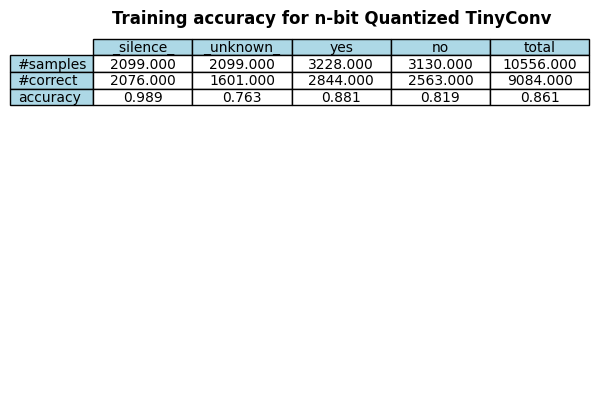

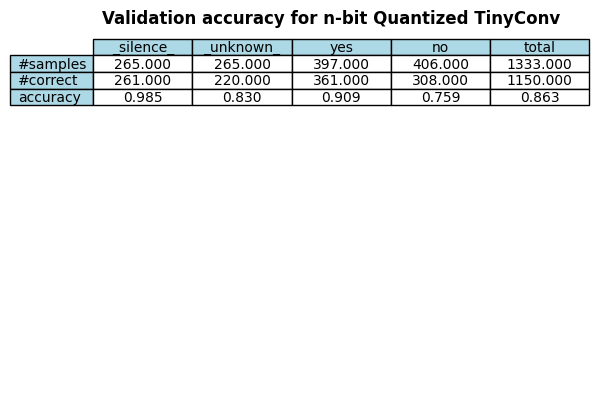

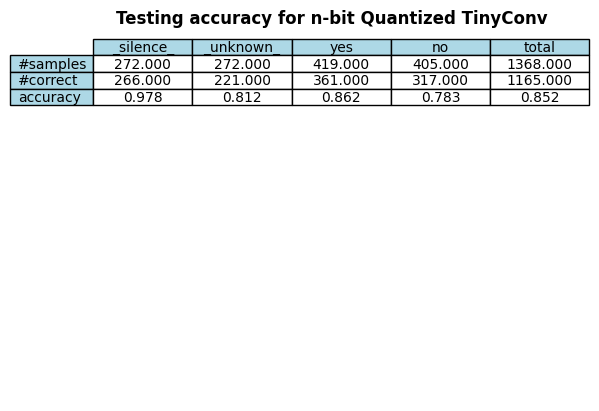

0.8516081871345029

In [ ]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device,
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_nbit, audio_processor, device,
    "Training", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_nbit, audio_processor, device,
    "Validation", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_nbit, audio_processor, device,
    'Testing', 'n-bit Quantized TinyConv', "float")

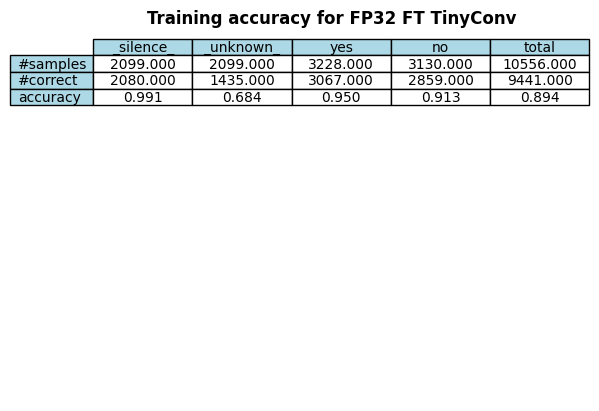

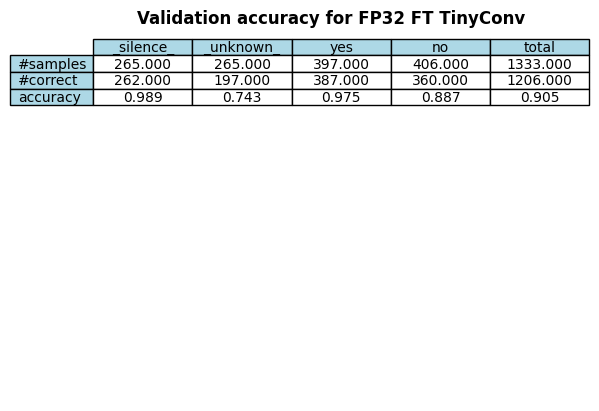

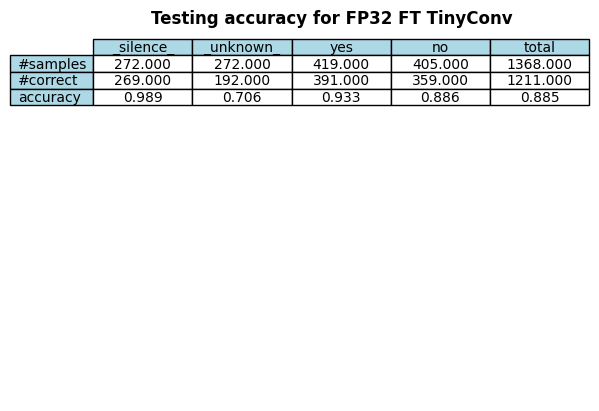

In [ ]:
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "Training", 'FP32 FT TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "Validation", 'FP32 FT TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'Testing', 'FP32 FT TinyConv', "float")

## 5.6 Saving the Trained Model

In [38]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_nbit_float = dequantize_model(qat_model_nbit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f'(QAT{QUANT_BITS}bit){file_name}.pt')
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_nbit.state_dict(), qat_torch_path)
qat_torch_path

Layer to be deprepared: QuantWrapper: conv
Layer to be deprepared: QuantWrapper: fc
The model's will be stored as: 
 quant_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/(QAT4bit)quant_0.pt'

## 5.7 Understanding and Evaluate the Effectiveness of Quantization-Aware Training (QAT)

### Model conversion: Quantized/Float Fine-tuning Model Converted to Integer Models

In [16]:
from src.quant import dequantize_model
from src.quant_conversion import convert_to_int

In [39]:
# Convert to quantized model

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_nbit = convert_to_int(
    qat_model_nbit, QUANT_BITS, dtype=torch.int32)

# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int32)

# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_nbit = dequantize_model(qat_model_nbit)

print(int_model_nbit)

Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: conv QuantWrapper(
  (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
	(bias): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
)
Staying the same: relu ReLU()
Staying the same: dropout Dropout(p=0.5, inplace=False)
Staying the same: fc_reshape Reshape(output_shape=(-1, 4000))
Staying the same: fc QuantWrapper(
  (module): Linear(in_features=4000, out_features=4, bias=True)
	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=None, prev_zeropoint=None, prev_min=None, prev_max=None  
	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=None, prev_zeropoint=None, prev_min=No

In [40]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_nbit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

Features from Quantized QAT Model
--------------------------------------------------------------------------------
features of Quantized QAT Model parameters:
conv.module.weight: min=-0.2770540416240692; max=0.1181977391242981; dtype=torch.float32; shape=torch.Size([8, 1, 10, 8])
conv.module.bias: min=-1.0440444946289062; max=0.21003559231758118; dtype=torch.float32; shape=torch.Size([8])
fc.module.weight: min=-0.2999028265476227; max=0.3266071379184723; dtype=torch.float32; shape=torch.Size([4, 4000])
fc.module.bias: min=-0.25222742557525635; max=0.48528730869293213; dtype=torch.float32; shape=torch.Size([4])
features of Quantized QAT Model activations/outputs
input: min=0.0; max=17.0703125; dtype=torch.float32; shape=torch.Size([1, 1960])
output of quant: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1960])
output of conv_reshape: min=0; max=15; dtype=torch.int32; shape=torch.Size([1, 1, 49, 40])
output of conv: min=-33.96807098388672; max=3.4829649925231934; dtype=torch.flo

### Compare the Performance Between Integer Models from Float/Quantized-Aware Finetuning

In [41]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model
# Percentage of same predictions shows how "quantization aware" the float point model is
_ = compare_model(test_loader, float_model_nbit, int_model_nbit)
_ = compare_model_mse(test_loader, float_model_nbit, int_model_nbit)

The models have 90.863% same predictions, 
Model1 predicts 88.816% of the samples correctly, 
Model2 predicts 85.088% of the samples correctly
MSE between two models' prediction: 0.0207


In [44]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model)

The models have 87.939% same predictions, 
Model1 predicts 89.912% of the samples correctly, 
Model2 predicts 83.918% of the samples correctly
MSE between two models' prediction: 0.0410


In [47]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)

#batches: 106 
#epochs: 10 
#total training steps: 1060


  0%|          | 0/10 [00:00<?, ?it/s]

Val Acc Epoch 1 = 66.54%, Train loss = 1.98
Val Acc Epoch 2 = 74.42%, Train loss = 0.956
Val Acc Epoch 3 = 76.97%, Train loss = 0.939
Val Acc Epoch 4 = 75.77%, Train loss = 0.798
Val Acc Epoch 5 = 80.72%, Train loss = 0.79
Val Acc Epoch 6 = 78.39%, Train loss = 0.797
Val Acc Epoch 7 = 80.27%, Train loss = 0.884
Val Acc Epoch 8 = 71.79%, Train loss = 0.823
Val Acc Epoch 9 = 74.87%, Train loss = 0.931
Val Acc Epoch 10 = 75.77%, Train loss = 0.863
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: conv QuantWrapper(
  (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
	(activation): quant_bits=2, quant_mode=asymmetric, prev_scale=8.502604484558105, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125  
	(weight): quant_bits=2, quant_mode=symmetric, prev_scale=0.15836361050605774, prev_zeropoint=0.0, prev_min=-0.15836361050605774, prev_max=0.15836361050605774  
	(bias): quant_bits=2, quant_mode=symmetric, prev_scale=0.3189820647

  0%|          | 0/10 [00:00<?, ?it/s]

Val Acc Epoch 1 = 77.94%, Train loss = 1.193
Val Acc Epoch 2 = 83.2%, Train loss = 0.635
Val Acc Epoch 3 = 85.75%, Train loss = 0.571
Val Acc Epoch 4 = 85.45%, Train loss = 0.538
Val Acc Epoch 5 = 87.25%, Train loss = 0.522
Val Acc Epoch 6 = 87.17%, Train loss = 0.491
Val Acc Epoch 7 = 88.82%, Train loss = 0.472
Val Acc Epoch 8 = 88.3%, Train loss = 0.448
Val Acc Epoch 9 = 88.15%, Train loss = 0.44
Val Acc Epoch 10 = 87.85%, Train loss = 0.47
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: conv QuantWrapper(
  (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
	(activation): quant_bits=4, quant_mode=asymmetric, prev_scale=1.6979167461395264, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.46875  
	(weight): quant_bits=4, quant_mode=symmetric, prev_scale=0.031443364918231964, prev_zeropoint=0.0, prev_min=-0.22010353207588196, prev_max=0.22010353207588196  
	(bias): quant_bits=4, quant_mode=symmetric, prev_scale=0.046920392662

  0%|          | 0/10 [00:00<?, ?it/s]

Val Acc Epoch 1 = 78.62%, Train loss = 1.433
Val Acc Epoch 2 = 82.22%, Train loss = 0.652
Val Acc Epoch 3 = 84.77%, Train loss = 0.578
Val Acc Epoch 4 = 85.22%, Train loss = 0.528
Val Acc Epoch 5 = 86.35%, Train loss = 0.496
Val Acc Epoch 6 = 86.12%, Train loss = 0.481
Val Acc Epoch 7 = 88.75%, Train loss = 0.476
Val Acc Epoch 8 = 87.92%, Train loss = 0.456
Val Acc Epoch 9 = 88.15%, Train loss = 0.437
Val Acc Epoch 10 = 88.52%, Train loss = 0.436
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: conv QuantWrapper(
  (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
	(activation): quant_bits=6, quant_mode=asymmetric, prev_scale=0.4048859477043152, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125  
	(weight): quant_bits=6, quant_mode=symmetric, prev_scale=0.006674795877188444, prev_zeropoint=0.0, prev_min=-0.20691867172718048, prev_max=0.20691867172718048  
	(bias): quant_bits=6, quant_mode=symmetric, prev_scale=0.007614

  0%|          | 0/10 [00:00<?, ?it/s]

Val Acc Epoch 1 = 80.05%, Train loss = 0.993
Val Acc Epoch 2 = 83.65%, Train loss = 0.608
Val Acc Epoch 3 = 85.45%, Train loss = 0.532
Val Acc Epoch 4 = 86.72%, Train loss = 0.49
Val Acc Epoch 5 = 87.7%, Train loss = 0.469
Val Acc Epoch 6 = 88.07%, Train loss = 0.451
Val Acc Epoch 7 = 88.0%, Train loss = 0.433
Val Acc Epoch 8 = 87.85%, Train loss = 0.438
Val Acc Epoch 9 = 87.4%, Train loss = 0.429
Val Acc Epoch 10 = 87.55%, Train loss = 0.417
Staying the same: conv_reshape Reshape(output_shape=(-1, 1, 49, 40))
Staying the same: conv QuantWrapper(
  (module): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
	(activation): quant_bits=8, quant_mode=asymmetric, prev_scale=0.10003064572811127, prev_zeropoint=-0.0, prev_min=0.0, prev_max=25.5078125  
	(weight): quant_bits=8, quant_mode=symmetric, prev_scale=0.001853085937909782, prev_zeropoint=0.0, prev_min=-0.23534192144870758, prev_max=0.23534192144870758  
	(bias): quant_bits=8, quant_mode=symmetric, prev_scale=0.001601372

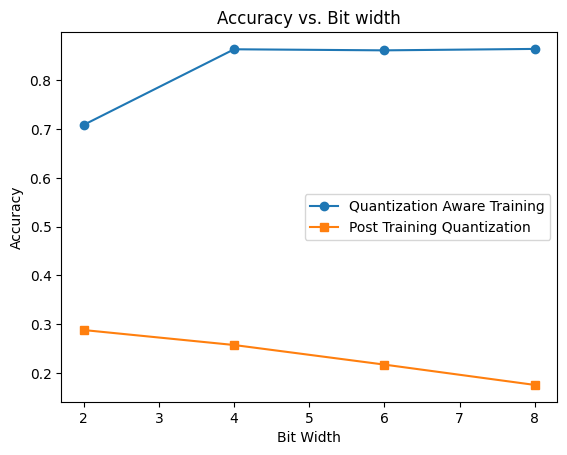

In [49]:
import os
import matplotlib.pyplot as plt
from src.train_val_test_utils import create_optimizer

def report_stuff(bits):
    """
    对给定的位宽列表 bits，
    1) 构造并训练 QAT 模型 (qat_model_nbit)
    2) 后量化 PTQ (post_quant_model)
    3) 在测试集上比较两者准确率
    返回:
      qat_accs: [qat_acc(bit=bits[0]), qat_acc(bit=bits[1]), ...]
      ptq_accs: [ptq_acc(bit=bits[0]), ptq_acc(bit=bits[1]), ...]
    """
    qat_accs = []
    ptq_accs = []
    for bit in bits:
        # 1. 创建一个浮点模型
        model_fp32 = TinyConv(model_settings=audio_processor.model_settings,
                              n_input=1, n_output=audio_processor.num_labels)

        # 2. 设置量化配置
        a_qconfig = QConfig(quant_bits=bit, is_symmetric=False)  # activations
        w_qconfig = QConfig(quant_bits=bit, is_symmetric=True)   # weights
        b_qconfig = QConfig(quant_bits=bit, is_symmetric=True)   # bias

        # 3. 生成可进行QAT的模型
        qat_model_nbit = quantize_model(model_fp32,
                                        a_qconfig=a_qconfig,
                                        w_qconfig=w_qconfig,
                                        b_qconfig=b_qconfig)

        verbose = False
        log_interval = 100
        num_batches = len(train_loader)
        n_epoch = 10
        print(f"#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}")

        # 4. 创建优化器并训练 (QAT)
        optimizer_quant = create_optimizer(model=qat_model_nbit, learning_rate=0.001)
        checkpoint_path = os.path.join(TORCH_DIR, f"quant_checkpoint_{bit}.pt")
        qat_model_nbit.to(device)

        run_training(
            model=qat_model_nbit, data_loaders=data_loaders,
            n_epoch=n_epoch, log_interval=log_interval,
            optimizer=optimizer_quant, scheduler=None,
            resume=False,
            checkpoint_path=checkpoint_path,
            verbose=verbose
        )

        # 5. 将QAT模型转换为量化 int 模型
        int_model_nbit = convert_to_int(qat_model_nbit, bit, dtype=torch.int32)

        # 6. 后量化 PTQ：将浮点模型转换为 int
        post_quant_model = convert_to_int(model_fp32, bit, dtype=torch.int32)

        # 7. 在测试集上比较二者准确率
        _, qat_acc, ptq_acc = compare_model(test_loader, int_model_nbit, post_quant_model)
        print(f"Bit={bit}: QAT Accuracy = {qat_acc}, PTQ Accuracy = {ptq_acc}")
        qat_accs.append(qat_acc)
        ptq_accs.append(ptq_acc)

    return qat_accs, ptq_accs

def main():
    # 你想要测试的量化位宽列表
    bits = [2, 4, 6, 8]

    # 调用 report_stuff 获得 QAT 与 PTQ 的准确率
    qat, ptq = report_stuff(bits)

    # 绘制对比图
    plt.figure()
    plt.plot(bits, qat, marker='o', label="Quantization Aware Training")
    plt.plot(bits, ptq, marker='s', label="Post Training Quantization")
    plt.title("Accuracy vs. Bit width")
    plt.xlabel("Bit Width")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


In [61]:
rm -f /content/gdrive/MyDrive/ece5545/a2-meridah7/.git/index.lock


In [68]:
%cd /content/gdrive/MyDrive/ece5545/a2-meridah7
!git add .



/content/gdrive/MyDrive/ece5545/a2-meridah7


In [69]:
!git commit -m "update source code"

[detached HEAD 4e7e3d2] update source code
 2 files changed, 2641 insertions(+), 953 deletions(-)
 rewrite 4_model_conversion.ipynb (95%)
 rewrite 5_quantization.ipynb (99%)


In [70]:
!git pull --no-rebase origin main


From https://github.com/ML-HW-SYS/a2-meridah7
 * branch            main       -> FETCH_HEAD
CONFLICT (modify/delete): 3_training_and_analysis.ipynb deleted in HEAD and modified in c4c434ee0e64a339fee7fe8a518614bed8073d99.  Version c4c434ee0e64a339fee7fe8a518614bed8073d99 of 3_training_and_analysis.ipynb left in tree.
Auto-merging 4_model_conversion.ipynb
CONFLICT (content): Merge conflict in 4_model_conversion.ipynb
Auto-merging 5_quantization.ipynb
CONFLICT (content): Merge conflict in 5_quantization.ipynb
Automatic merge failed; fix conflicts and then commit the result.
